Define example posteriors.

In [17]:
class Posterior:
    def __init__(self,lower:float, upper:float, color:str, name:str, distribution_type="uniform") -> None:
        self.lower = lower
        self.upper = upper
        self.color = color
        self.name = name
        self.distribution_type = distribution_type
        return
    
    def get_bounds(self):
        return [self.lower, self.upper]
    
    def get_pdf(self,x): # uniform for now I'm lazy
        return 1/(self.upper - self.lower)

# put in your posteriors in the order you want them graphed
aspirin = Posterior(lower=0.23, upper=0.3, name="Aspirin", color="blue")
placebo = Posterior(lower=0.15, upper=0.25, name="Placebo", color="red")
caffeine = Posterior(lower=0.2, upper=0.4, name="Caffiene", color="orange")
cyanide = Posterior(lower=0, upper=0.002, name="Cyanide", color="green")

posteriors = [aspirin,
              placebo,
              caffeine,
              cyanide]


Plotting examples

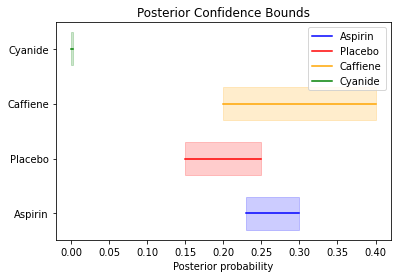

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()
bar_width = 0.3

# Plot the first horizontal line (stick) with confidence interval

count = 1 # determines y-position on graph

for posterior in posteriors:
    ax.plot([posterior.lower, posterior.upper], 
            [count, count], label=posterior.name, color=posterior.color)
    ax.fill_betweenx([count - bar_width, count + bar_width], posterior.lower, posterior.upper,
                      color=posterior.color, alpha=0.2)

    count += 1 # increment height

# Add labels and title
ax.set_xlabel('Posterior probability')
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels([posterior.name for posterior in posteriors])
ax.set_title(f"Posterior Confidence Bounds")

# Add a legend
ax.legend()

### Find IsMax for each assuming uniform distribution

<u> Independence of Posteriors (mostly) </u>:

Suppose we have $k$ posteriors (this includes $M_{other}$, the combined posterior that anything not in our selected 'causes' was the cause). Treat each $M_i \in \mathcal{M}$ as a random variable.
Then, **if the sum of upper bounds of every posterior in $\mathcal{M}$ does not exceed 1**, we can let the first $k-1$ causes be independent (because of this upper bound, selecting *any* random posteriors within this range and adding them up will *never* exceed 1) while the last posterior, $M_{other}$, is a fully dependent random variable $M_{other} = 1-\sum_i{M_i}$. 

<u> Pr(IsMax(M_i)) is just expected value of an indicator function </u>:

For simplicity let $X$, $Y$, $Z$, ... be the chosen (independent) posterior random variables, and let $x$, $y$, and $z$ be the specific values they take on. Also, suppose we are finding the probability that $X$ is the maximum posterior. Then, let this be the indicator function that x is the maximum.
$$
\mathbf{1}_{\{{x}_{max}\}}(x,y,z) = \begin{cases} 
1 & \text{if } x = \max(\{x,y,z,1-(x+y+z)\}) \\ 
0 & \text{otherwise }
\end{cases}
$$

The expected value of this indicator function basically is the same value as (1) tallying up the total number of configurations of $x$, $y$, $z$, (and $(1-x-y-z)$) where $x$ is the maximum, and then (2) dividing it by the total number of configurations of $x$, $y$, and $z$. This is the same thing as the probability that $X=x$ is the maximum.

We can find this with LOTUS:

$$
\begin{align*}
\Pr(IsMax(X)) &= \int_{x_l}^{x_u} \int_{y_l}^{y_u} \int_{z_l}^{z_u} \mathbf{1}_{\{{x}_{max}\}}(x,y,z)f(x, y, z) \, dz \, dy \, dx\\
&= \int_{x_l}^{x_u} \int_{y_l}^{y_u} \int_{z_l}^{z_u} \mathbf{1}_{\{{x}_{max}\}}(x,y,z)f(x)f(y)f(z) \, dz \, dy \, dx\\
\end{align*}
$$


In [59]:
def indicator(x,y,z):
    return int(x == max(x,y,z,1-(x+y+z))) # ew

def integrand(x:float, x_obj:Posterior, y:float, y_obj:Posterior, 
              z:float, z_obj:Posterior):
    """integrand for expected value"""
    return indicator(x,y,z)*x_obj.get_pdf(x)*y_obj.get_pdf(y)*z_obj.get_pdf(z)


Estimate the integral (Monte-carlo integration technique, scipy complained)

In [61]:
import scipy.integrate as spi
from typing import List

def monte_carlo_integration(function, x_obj, y_obj, z_obj, num_samples=10000000):
    """
    Estimate the integral of a function over a 3D domain using Monte Carlo integration.

    Parameters:
    - function: callable, the function to integrate. It should accept three arguments (x, y, z).
    - bounds1: tuple, the lower and upper bounds for the first variable (x).
    - bounds2: tuple, the lower and upper bounds for the second variable (y).
    - bounds3: tuple, the lower and upper bounds for the third variable (z).
    - num_samples: int, the number of random samples to use for the estimation (default: 1,000,000).

    Returns:
    - integral_estimate: float, the estimated value of the integral.
    - standard_error: float, the estimated standard error of the integral.
    """
    x_l, x_u = x_obj.lower, x_obj.upper
    y_l, y_u = y_obj.lower, y_obj.upper
    z_l, z_u = z_obj.lower, z_obj.upper

    # Generate random samples
    x_samples = np.random.uniform(x_l, x_u, num_samples)
    y_samples = np.random.uniform(y_l, y_u, num_samples)
    z_samples = np.random.uniform(z_l, z_u, num_samples)

    # Evaluate the integrand at the sample points
    sample_evaluations = np.array([function(x, y, z) for x, y, z in zip(x_samples, y_samples, z_samples)])

    # Compute the volume of the integration region
    volume = (x_u - x_l) * (y_u - y_l) * (z_u - z_l)

    # Estimate the integral as the mean of the evaluations times the volume
    integral_estimate = volume * np.mean(sample_evaluations)

    # Compute the standard error of the mean
    standard_error = volume * np.std(sample_evaluations) / np.sqrt(num_samples)

    return integral_estimate, standard_error


integral_estimate, standard_error = monte_carlo_integration(lambda x,y,z: integrand(x, aspirin, y, placebo, z, caffeine), aspirin, placebo, caffeine) # first posterior is the one you care about
print(f"Estimated integral: {integral_estimate}")
print(f"Estimated standard error: {standard_error}")
# def get_prob_max(chosen:Posterior, rest:List[Posterior]):

#     result, error = spi.nquad(lambda x,y,z: integrand(x, chosen, y, rest[0], z, rest[1]), 
#                             [chosen.get_bounds(), rest[0].get_bounds(), rest[1].get_bounds()])
#     return result/((chosen.upper-chosen.lower)*(rest[0].upper-rest[0].lower)* 
#                     (rest[1].upper-rest[1].lower)),\
#                         error

# OLD METHOD -- more accurate but very slow (crashed my computer :,()
# integral: 0.12152689380300634
# error: 4.355289129863438e-08

# def get_prob_max(chosen:Posterior, rest:List[Posterior]):
#     result, error = spi.nquad(lambda x,y,z: integrand(x, chosen, y, rest[0], z, rest[1]), 
#                             [chosen.get_bounds(), rest[0].get_bounds(), rest[1].get_bounds()])
#     return result/((chosen.upper-chosen.lower)*(rest[0].upper-rest[0].lower)* 
#                     (rest[1].upper-rest[1].lower)),\
#                         error



Estimated integral: 0.12160799999999986
Estimated standard error: 0.0001033535167935757


In [64]:
integral_estimate_aspirin, standard_error_aspirin = monte_carlo_integration(lambda x,y,z: integrand(x, aspirin, y, placebo, z, caffeine), aspirin, placebo, caffeine) # first posterior is the one you care about
print(f"Estimated integral: {integral_estimate_aspirin}")
print(f"Estimated standard error: {standard_error_aspirin}")

Estimated integral: 0.12142870000000013
Estimated standard error: 0.00010328783607778307


In [66]:
# same with placebo (this is zero since C_other would have the maximum posterior)
integral_estimate_placebo, standard_error_placebo = monte_carlo_integration(lambda x,y,z: integrand(x, placebo, y, aspirin, z, caffeine), placebo, aspirin, caffeine) # first posterior is the one you care about
print(f"Placebo integral: {integral_estimate_placebo}")
print(f"Estimated standard error: {standard_error_placebo}")

Placebo integral: 0.0
Estimated standard error: 0.0


In [65]:
integral_estimate_caffiene, standard_error_caffiene = monte_carlo_integration(lambda x,y,z: integrand(x, caffeine, y, aspirin, z, placebo), caffeine, placebo, aspirin) # first posterior is the one you care about
print(f"Caffeine integral: {integral_estimate_caffiene}")
print(f"Estimated standard error: {standard_error_caffiene}")

Caffeine integral: 0.5981094
Estimated standard error: 0.0001550401708047434


This means that Pr(IsMax(M_other))= 1-(0.5981094 + 0.12142870000000013) = 0.2804618999999998

In [67]:
1-(0.5981094 + 0.12142870000000013)

0.2804618999999998

Ignore everything below from here (Rough work)

In [ ]:
result

0.00017013765132420884

This was the scipy method for calculating probability of aspirin, it's more accurate apparent

In [48]:
result/((caffeine.upper-caffeine.lower)*(aspirin.upper-aspirin.lower)*(placebo.upper-placebo.lower))

0.12152689380300634

In [30]:
error

4.355289129863438e-08

In [58]:
1/8

0.125